# Install Libraries

In [ ]:
!pip install kaggle tensorflow keras numpy matplotlib pillow mtcnn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.1 MB/s eta 0:00:00


# Setup Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityakadam3101","key":"6227205d724ce690fd3f9356d5fef440"}'}

# Enable Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Dataset

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 86% 90.0M/105M [00:00<00:00, 942MB/s]
100% 105M/105M [00:00<00:00, 918MB/s] 


# Extract Dataset

In [ ]:
import zipfile, os

with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip","r") as z:
    z.extractall("dataset")

print("Extracted:", os.listdir("dataset"))

Extracted: ['train', 'test']


# Auto Fix Dataset Path

In [ ]:
base_path = "dataset"
for f in os.listdir(base_path):
    if "cifake" in f.lower():
        base_path = os.path.join(base_path,f)

train_dir = os.path.join(base_path,"train")
test_dir  = os.path.join(base_path,"test")

print("Train Path:", train_dir)
print("Classes:", os.listdir(train_dir))

Train Path: dataset/train
Classes: ['FAKE', 'REAL']


# View Sample Images

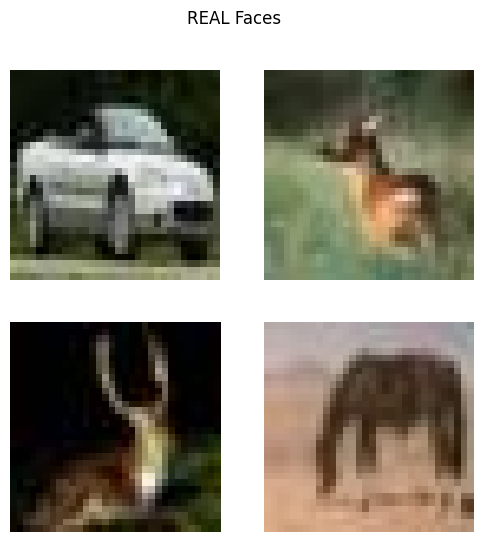

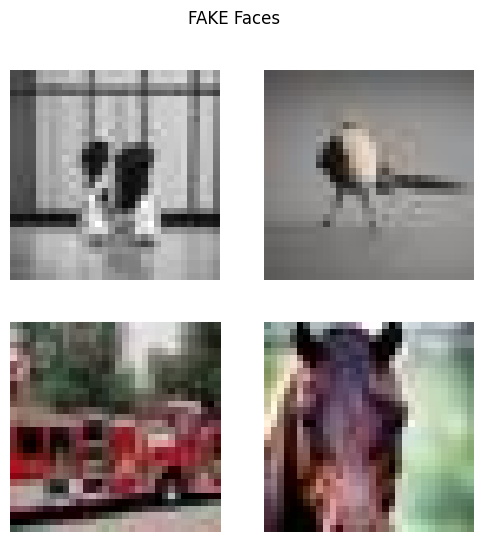

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def show_samples(path,title):
    imgs = os.listdir(path)
    s = random.sample(imgs,4)

    plt.figure(figsize=(6,6))
    for i,img in enumerate(s):
        image = Image.open(os.path.join(path,img))
        plt.subplot(2,2,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(os.path.join(train_dir,"REAL"),"REAL Faces")
show_samples(os.path.join(train_dir,"FAKE"),"FAKE Faces")

# Load Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

img_size = (224,224)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print(train_data.class_indices)
print("Train samples:", train_data.samples)
print("Val samples:", val_data.samples)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
{'FAKE': 0, 'REAL': 1}
Train samples: 100000
Val samples: 20000


# Build Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128,activation="relu"),
    Dropout(0.4),
    Dense(1,activation="sigmoid")
])

model.compile(
    optimizer=Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Train Model

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=8
)


Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 182s 50ms/step - accuracy: 0.8437 - loss: 0.3572 - val_accuracy: 0.8943 - val_loss: 0.2494
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 145s 46ms/step - accuracy: 0.8911 - loss: 0.2644 - val_accuracy: 0.9203 - val_loss: 0.1987
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 148s 47ms/step - accuracy: 0.9024 - loss: 0.2378 - val_accuracy: 0.9094 - val_loss: 0.2185
Epoch 4/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 147s 47ms/step - accuracy: 0.9063 - loss: 0.2289 - val_accuracy: 0.9289 - val_loss: 0.1790
Epoch 5/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 154s 49ms/step - accuracy: 0.9082 - loss: 0.2229 - val_accuracy: 0.9231 - val_loss: 0.1866
Epoch 6/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 146s 47ms/step - accuracy: 0.9158 - loss: 0.2101 - val_accuracy: 0.9329 - val_loss: 0.1649
Epoch 7/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 147s 47ms/step - accuracy: 0.9188 - loss: 0.2026 - val_accuracy: 0.9357 - val_loss: 0.1610
Epoch 8/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 146s 47ms/step - accuracy: 0.9187 - loss: 0.2

# Plot Accuracy

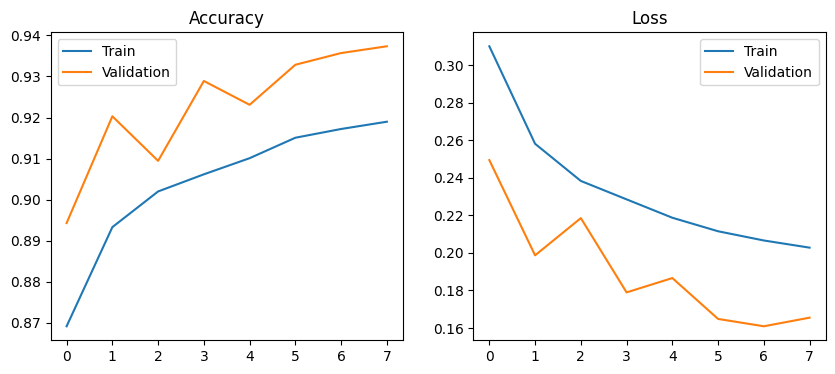

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],label="Train")
plt.plot(history.history["val_accuracy"],label="Validation")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Train")
plt.plot(history.history["val_loss"],label="Validation")
plt.legend()
plt.title("Loss")

plt.show()

# Evaluate

In [ ]:
loss,acc = model.evaluate(val_data)
print("Validation Accuracy =", acc)

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9508 - loss: 0.1275
Validation Accuracy = 0.9373499751091003


# Face Detection

In [ ]:
from mtcnn import MTCNN
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

detector = MTCNN()

def detect_and_crop_face(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(img_rgb)

    if faces == []:
        print("No face detected")
        return None

    x,y,w,h = faces[0]['box']

    if x < 0: x = 0
    if y < 0: y = 0

    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face,(224,224))

    face = face.astype("float32")
    face = preprocess_input(face)
    face = np.expand_dims(face,axis=0)
    return face

# Upload Image

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WIN_20240613_16_37_43_Pro.jpg to WIN_20240613_16_37_43_Pro (1).jpg


# Predict

In [ ]:
img_name = list(uploaded.keys())[0]
face = detect_and_crop_face(img_name)

if face is not None:
    pred = model.predict(face)[0][0]
    print("Prediction value =",pred)

    if pred > 0.5:
        print("REAL FACE ✔️")
    else:
        print("FAKE FACE ❌ (AI Generated)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction value = 0.1444739
FAKE FACE ❌ (AI Generated)


# Save Model

In [ ]:
model.save("Deepfake_Detector_FacePipeline.h5")
print("Model Saved")

Model Saved
